# Logistic Regression from Scratch
## - Steven Kolawole                                

## Intro

Logistic Regression is simply a Linear Regression with a Sigmoid function at its end.

The Sigmoid function generates probability (i.e. outputs between 0 and 1) for all values of X.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

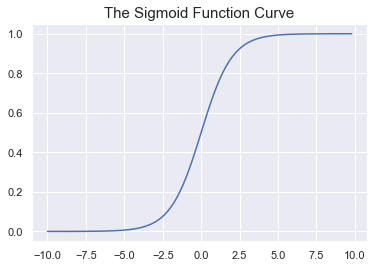

In [2]:
def sigmoid_fxn(x):
    yhat = list(map(lambda i: 1 / (1 + np.exp(-i)), x))
    return yhat

x = np.arange(-10., 10., 0.2)
logit = sigmoid_fxn(x)
plt.title("The Sigmoid Function Curve", fontsize=15)

plt.plot(x, logit)
plt.show()

## Building my Customized Logistic Regression

In [17]:
class LogisticClassifier():
    def __init__(self, 
            learning_rate=0.1, 
            tolerance=1e-4, 
            max_iter=1000, 
            batch_size=32, 
            momentum_decay=0.9, 
            early_stopping=3, 
            validation_set=(None,None)):
        
        # Gradient descent parameters
        self.learning_rate = float(learning_rate)
        self.tolerance = float(tolerance)
        self.max_iter = int(max_iter)
        self.batch_size=32
        self.momentum_decay = float(momentum_decay)
        self.early_stopping = int(early_stopping)
        self.X_validation, self.y_validation = validation_set
        
        # to construct the design matrix
        self.add_intercept = True
        self.center = True 
        self.scale = True
        
        self.training_loss_history = []
        
    def __sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    # z-score normalization and intercept addition
    def __design_matrix(self, X):
        if self.center:
            X = X - self.means
        if self.scale:
            X = X / self.standard_error
        if self.add_intercept:
            intercept = np.ones((X.shape[0], 1))
            X = np.hstack([intercept, X])
            
        return X
    
    def __fit_center_scale(self, X):
        self.means = X.mean(axis=0)
        self.standard_error = np.std(X, axis=0)
        
    def fit(self, X, y):
        self.__fit_center_scale(X)

        n, k = X.shape
        
        # add intercept column to the design matrix
        X = self.__design_matrix(X)

        # used for the convergence check
        previous_loss = -float('inf')
        self.converged = False
        self.stopped_early = False
        
        # initialize parameters
        self.beta = np.zeros(k + (1 if self.add_intercept else 0))
        momentum = self.beta * 0  # to get the same shape and dtype as beta
        
        for i in range(self.max_iter):
            shuffle = np.random.permutation(len(y))
            X = X[shuffle, :]
            y = y[shuffle]
            
            # we'll add one more batch, incase the batch size doesn't divide n evenly
            extra = (1 if n % self.batch_size else 0)

            for batch_index in range(n // self.batch_size + extra):
                batch_slice = slice(
                    self.batch_size * batch_index, 
                    self.batch_size * (batch_index + 1) )
                X_batch = X[batch_slice, :]
                y_batch = y[batch_slice]
            
                beta_ahead = self.beta + self.momentum_decay * momentum
                y_hat = self.__sigmoid(np.dot(X_batch, self.beta))
                
                # gradient descent
                residuals = (y_hat - y_batch).reshape( (X_batch.shape[0], 1) )
                gradient = (X_batch * residuals).mean(axis=0)
                momentum = self.momentum_decay * momentum - self.learning_rate * gradient
                self.beta += momentum

            # with minibatch, we only check convergence at the end of every epoch.    
            y_hat = self.__sigmoid(np.dot(X, self.beta))
            self.loss = np.mean(-y * np.log(y_hat) - (1-y) * np.log(1-y_hat))
            self.training_loss_history.append(self.loss)
            
            # early stopping
            if self.check_validation_loss():
                self.stopped_early = True
                break 
                
            if abs(previous_loss - self.loss) < self.tolerance:
                self.converged = True
                break
            else:
                previous_loss = self.loss
        
        self.iterations = i+1
        
    def predict_proba(self, X):
        # add intercept column to the design matrix
        X = self.__design_matrix(X)
        return self.__sigmoid(np.dot(X, self.beta))

    def predict(self, X):
        predictions = self.predict_proba(X).round()
        return predictions

    def check_validation_loss(self):
        # validation set loss
        if not hasattr(self, 'validation_loss_history'):
            self.validation_loss_history = []
        p_hat = self.predict_proba(self.X_validation)
        loss = np.mean(-self.y_validation * np.log(p_hat) - \
               (1-self.y_validation) * np.log(1-p_hat))
        self.validation_loss_history.append(loss)
        
        t = self.early_stopping
        if t and len(self.validation_loss_history) > t * 2:
            recent_best = min(self.validation_loss_history[-t:])
            previous_best = min(self.validation_loss_history[:-t])
            if recent_best > previous_best:
                return True
        return False

## Testing and Evaluating the Customized Model

In [18]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split as tts

dummy_data = load_breast_cancer()
X, y = dummy_data.data, dummy_data.target

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=103)

In [19]:
model = LogisticClassifier(learning_rate = 0.01,
                           tolerance=1e-5,
                           max_iter=2000,
                           early_stopping=3,
                           validation_set=(X_test, y_test))

In [20]:
model.fit(X_train, y_train)

In [21]:
y_pred = model.predict(X_test)

In [22]:
# defining the metrics function
def accuracy(predictions, actual):
    return sum(predictions == actual) / len(actual)

In [23]:
accuracy(y_pred, y_test)

0.9736842105263158